In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.stats import linregress
import os
import glob

%config InlineBackend.figure_format = 'retina'

# streamlined visualization

In [2]:
directory = r"\\wsl$\Ubuntu-18.04\home\arlenlex\LIGGGHTS_SEAICE\lexi_tests\bond_tension\post"

In [3]:
def create_bond_df(directory):
    '''
    Function for parsing LIGGGHTS bond files. 
    Computes bond force magnitude (b_fmag) in addition to other variables.
    Organizes data so that df['bfx'] gives an array of values across all timesteps.
    '''
    bond_variable_names = ["x1", "y1", "z1", "x2", "y2", "z2",
                           "batom1", "batom2", "btype", "bfx", "bfy", "bfz",
                           "btx", "bty", "btz", "beqdist"] 

    # Initialize a dictionary to store lists for each variable, including b_fmag
    data_dict = {var: [] for var in bond_variable_names}
    data_dict['b_fmag'] = []
    timesteps = []

    fpaths = sorted(glob.glob(directory + r'\*.bond'))

    # Loop over all files in the directory
    for fname in fpaths:
            
        # Open and read the file
        with open(fname, 'r') as file:
            lines = file.readlines()
            
            # Extract the timestep; on the second line
            timestep = int(lines[1].strip())
            timesteps.append(timestep)

            # Extract the data line; data is on the last line
            data_line = lines[-1]
            vals = list(map(float, data_line.split()))
            
            # Store each data value under its corresponding variable name
            for i, var in enumerate(bond_variable_names):
                data_dict[var].append(vals[i])

            # Calculate the force magnitude (b_fmag) and store it
            bfx, bfy, bfz = vals[9], vals[10], vals[11]
            bond_force_magnitude = np.sqrt(bfx**2 + bfy**2 + bfz**2)
            data_dict['b_fmag'].append(bond_force_magnitude)
                    
    # Create a DataFrame where each column contains an array of values across timesteps
    df = pd.DataFrame({var: pd.Series(data_dict[var], index=timesteps) for var in data_dict})

    dt = 100/timesteps[0] # approximate due to ceil function
    
    return dt, df


In [4]:
dt, df_bond = create_bond_df(directory)

In [5]:
def create_atom_df(directory):
    atom_variable_names = ['id', 'atype', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'fx',
                            'fy', 'fz', 'omegax', 'omegay', 'omegaz', 'radius']
    
    # Initialize a dictionary to store DataFrames for each atom ID
    atom_data = {}
    timesteps = []

    fpaths = sorted(glob.glob(directory + r'\*.liggghts'))

    # Loop over all dump files in the simulation directory
    for fname in fpaths:
        # Open and read the file
        with open(fname, 'r') as file:
            lines = file.readlines()
            
            # Extract the timestep; on the second line
            timestep = int(lines[1].strip())
            timesteps.append(timestep)
            
            # Extract the number of atoms; on the fourth line
            num_atoms = int(lines[3].strip())
            
            # Extract the atom data starting from the ninth line
            for i in range(num_atoms):
                data_line = lines[9 + i].strip()
                vals = list(map(float, data_line.split()))
                
                # Atom ID is the first value in the data line
                atom_id = int(vals[0])
                
                # Calculate the force magnitude for the atom
                fx, fy, fz = vals[8], vals[9], vals[10]
                atom_force_magnitude = np.sqrt(fx**2 + fy**2 + fz**2)
                
                # Add force magnitude to the list of variables
                vals.append(atom_force_magnitude)
                
                # If the atom ID doesn't have a DataFrame yet, create one
                if atom_id not in atom_data:
                    atom_data[atom_id] = {var: [] for var in atom_variable_names + ['atom_fmag']}
                    atom_data[atom_id]['timestep'] = []
                
                # Append the values for this timestep
                for j, var in enumerate(atom_variable_names + ['atom_fmag']):
                    atom_data[atom_id][var].append(vals[j])
                atom_data[atom_id]['timestep'].append(timestep)

    # Convert each atom's dictionary into a DataFrame and store in a new dictionary
    atom_dfs = {}
    for atom_id, data_dict in atom_data.items():
        atom_dfs[atom_id] = pd.DataFrame(data_dict).set_index('timestep')
    
    # Concatenate the atom DataFrames into a MultiIndex DataFrame
    final_df = pd.concat(atom_dfs, axis=1)

    dt = 100/timesteps[0] # approximate due to ceil function
    
    return dt, final_df


In [6]:
dt, df_atom = create_atom_df(directory)

In [29]:
df_bond.keys()

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'batom1', 'batom2', 'btype', 'bfx',
       'bfy', 'bfz', 'btx', 'bty', 'btz', 'beqdist', 'b_fmag'],
      dtype='object')

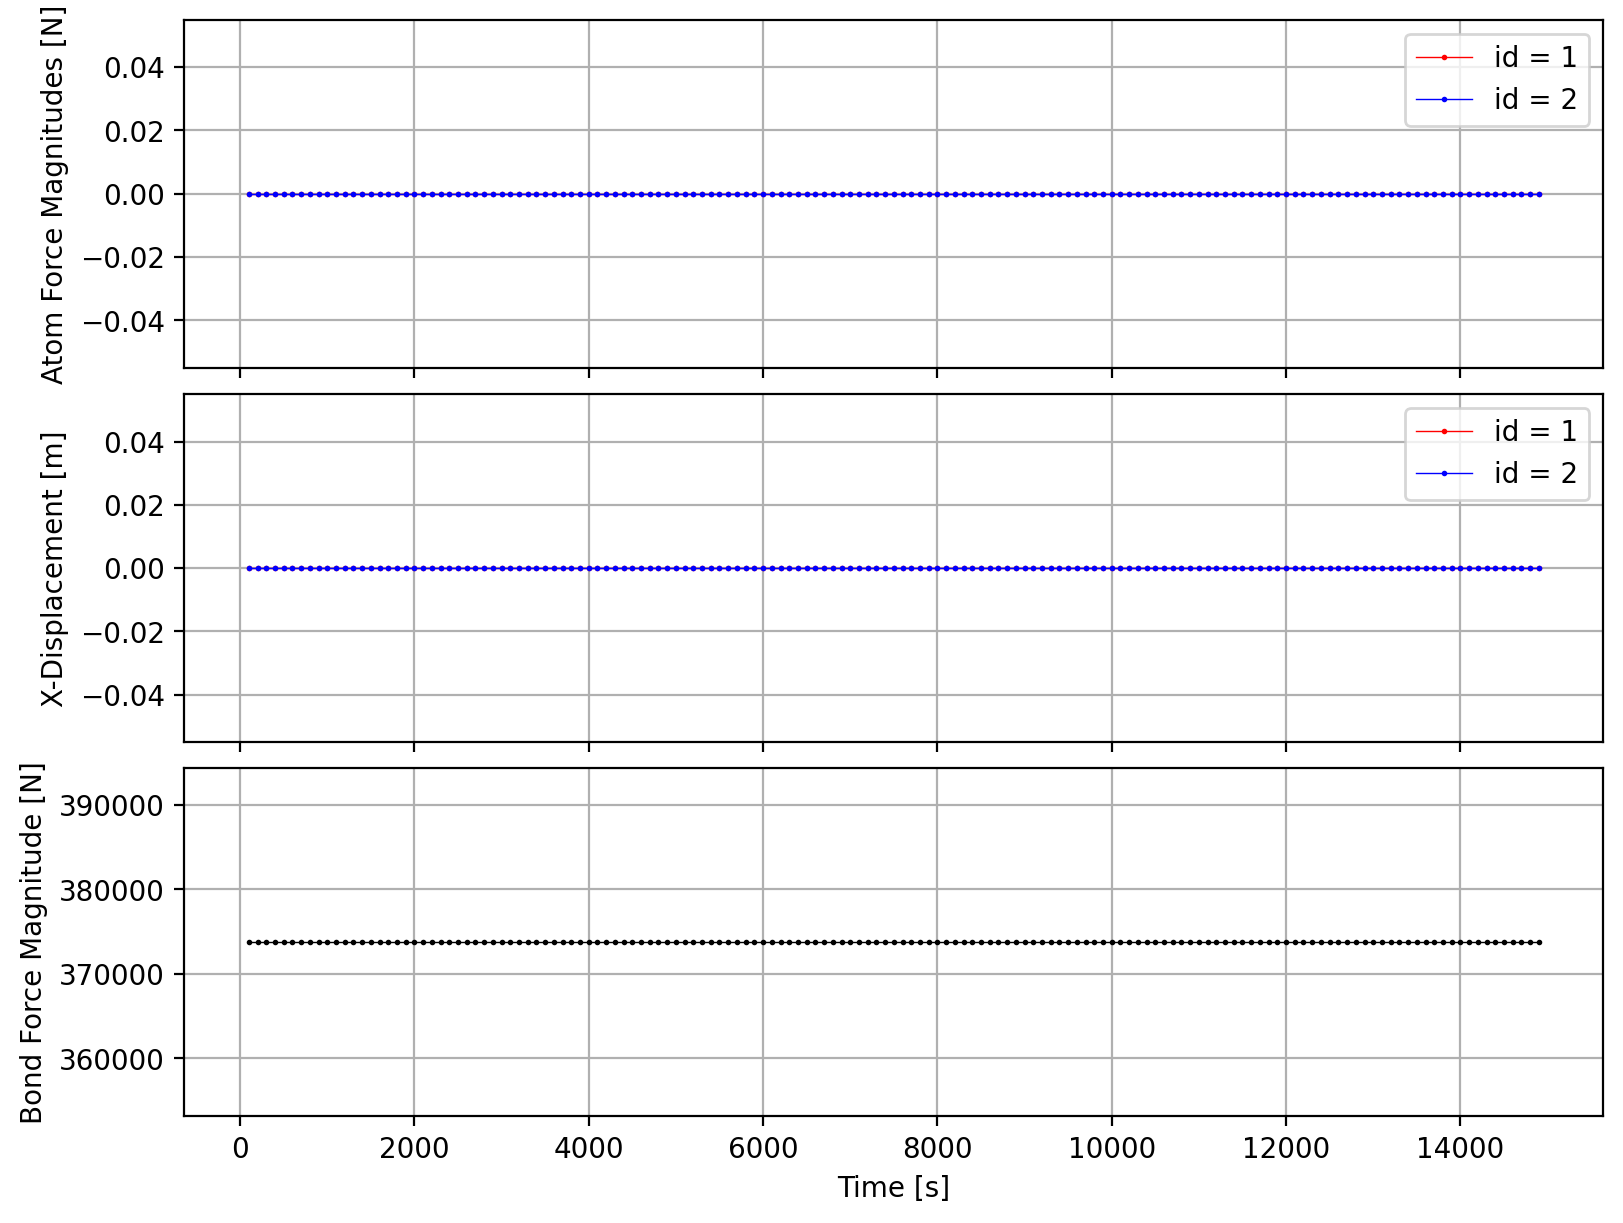

In [41]:
fig, ax = plt.subplots(3,1, layout = 'constrained', sharex=True, figsize = (8,6))

plt.sca(ax[0])
id = 1
plt.plot(df_atom.index.values * dt, df_atom[id]['atom_fmag'], 'o-', color = 'r', lw = 0.5, markersize = 1, label = f'id = {id}')
id = 2
plt.plot(df_atom.index.values * dt, df_atom[id]['atom_fmag'], 'o-', color = 'b', lw = 0.5, markersize = 1, label = f'id = {id}')
plt.ylabel('Atom Force Magnitudes [N]')
plt.grid(True)
plt.legend()

plt.sca(ax[1])
id = 1
plt.plot(df_atom.index.values * dt, df_atom[id]['x'].values - df_atom[id]['x'].values[0], 'o-', color = 'r', lw = 0.5, markersize = 1, label = f'id = {id}')
id = 2
plt.plot(df_atom.index.values * dt, df_atom[id]['x'].values - df_atom[id]['x'].values[0], 'o-', color = 'b', lw = 0.5, markersize = 1, label = f'id = {id}')
plt.ylabel('X-Displacement [m]')
plt.grid(True)
plt.legend()

plt.sca(ax[2])
plt.plot(df_bond.index.values * dt, df_bond['b_fmag'].values, 'o-', color = 'k', lw = 0.5, markersize = 1)
plt.xlabel('Time [s]')
plt.ylabel('Bond Force Magnitude [N]')
plt.grid(True)

plt.show()

In [7]:
# Function to parse a single dump file
def parse_dump_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    timestep = int(lines[1].strip())
    num_atoms = int(lines[3].strip())
    
    atom_data = []
    for line in lines[9:9 + num_atoms]:  # Assumes atom data starts at line 9
        atom_data.append([float(x) for x in line.strip().split()])
    
    # Convert to a DataFrame for easier manipulation
    df = pd.DataFrame(atom_data, columns=["id", "type", "x", "y", "z", "id_1", "id_2", "id_3", "id_4", 
                                          "vx", "vy", "vz", "fx", "fy", "fz", "omegax", "omegay", "omegaz", "radius"])
    
    return timestep, df

# Function to create an xarray Dataset from multiple dump files
def create_xarray_from_dumps(filepaths):
    datasets = []
    timesteps = []
    
    for filepath in filepaths:
        timestep, df = parse_dump_file(filepath)
        timesteps.append(timestep)
        
        # Convert DataFrame to Dataset
        ds = df.set_index("id").to_xarray()
        ds = ds.expand_dims("time")
        ds = ds.assign_coords(time=[timestep])
        
        datasets.append(ds)
    
    # Combine datasets along the time dimension
    full_dataset = xr.concat(datasets, dim="time")
    return full_dataset

# Example usage
filepaths = ["dump1.txt", "dump2.txt"]  # Replace with actual file paths
dataset = create_xarray_from_dumps(filepaths)

# Example: Accessing data for atom 1 at timestep 521180
atom_1_timestep_521180 = dataset.sel(time=521180, id=1)
print(atom_1_timestep_521180)


# try reading bond dump files to plot forces

In [2]:
dt = 0.000126939 # from screen; hardcode to make life easier

In [14]:
# Path to the directory containing the bond files
directory = "post_lower_force"

# Variable names as they appear in the data lines
variable_names = [
    "x1", "y1", "z1", "x2", "y2", "z2",
    "batom1", "batom2", "btype1", "btype2", "fx", "fy", "fz",
    "tx", "ty", "tz", "beqdist"
]

# Initialize a dictionary to store lists for each variable
data_dict = {var: [] for var in variable_names}
timesteps = []

# Loop over all files in the directory
for filename in sorted(os.listdir(directory)):
    if filename.startswith("bfc") and filename.endswith(".bond"):
        
        # Open and read the file
        with open(os.path.join(directory, filename), 'r') as file:
            lines = file.readlines()
            
            # Extract the timestep; on the second line
            timestep = int(lines[1].strip())
            timesteps.append(timestep)


            # Extract the data line; data is on the last line
            data_line = lines[-1]
            vals = list(map(float, data_line.split()))
            
            # Store each data value under its corresponding variable name
            for i, var in enumerate(variable_names):
                data_dict[var].append(vals[i])
                
# Create an xarray.Dataset using the collected data
data = xr.Dataset(
    {var: ("timestep", data_dict[var]) for var in variable_names},
    coords={"timestep": timesteps}
)

In [15]:
# sort and display the dataset, also compute the force magnitude
data = data.sortby("timestep")
data["force_magnitude"] = np.sqrt(data.fx**2 + data.fy**2 + data.fz**2)
print(data)

<xarray.Dataset> Size: 140kB
Dimensions:          (timestep: 943)
Coordinates:
  * timestep         (timestep) int32 4kB 1060 2120 3180 ... 998520 999580
Data variables: (12/18)
    x1               (timestep) float64 8kB 100.0 100.0 100.0 ... 100.0 100.0
    y1               (timestep) float64 8kB 100.0 100.0 100.0 ... 100.0 100.0
    z1               (timestep) float64 8kB 100.0 100.0 100.0 ... 100.0 100.0
    x2               (timestep) float64 8kB 200.0 200.0 200.0 ... 200.0 200.0
    y2               (timestep) float64 8kB 100.0 100.0 100.0 ... 100.0 100.0
    z2               (timestep) float64 8kB 100.0 100.0 100.0 ... 100.0 100.0
    ...               ...
    fz               (timestep) float64 8kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tx               (timestep) float64 8kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ty               (timestep) float64 8kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tz               (timestep) float64 8kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    beqd

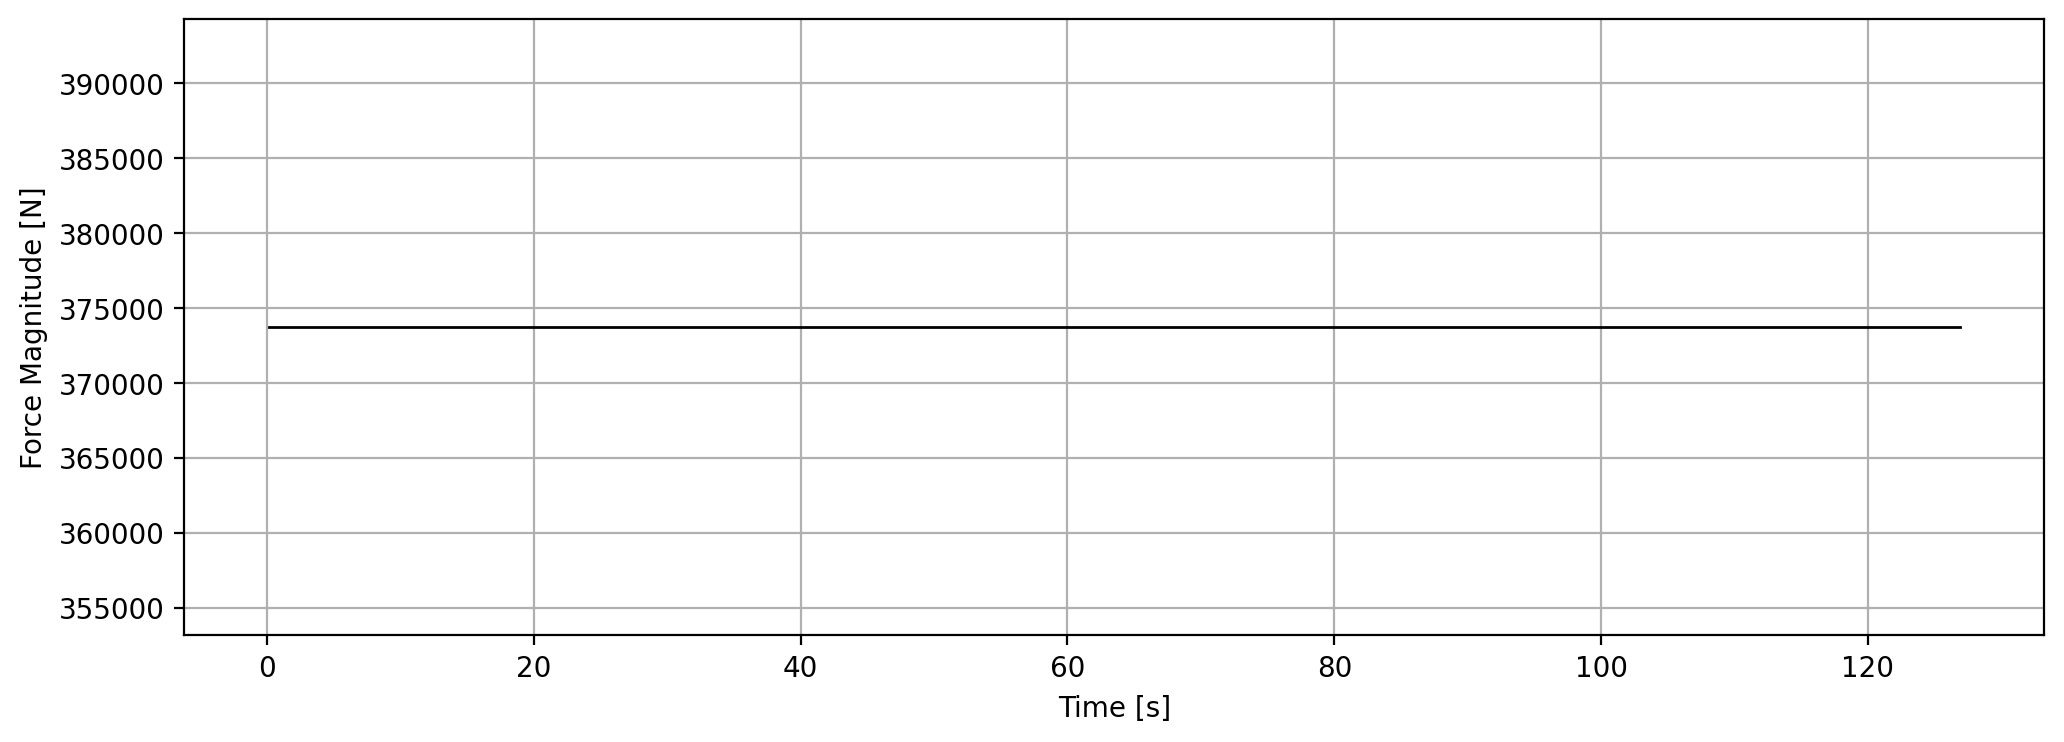

In [16]:
# If you want to plot the force magnitude vs timestep
plt.figure(figsize=(12,4))
plt.plot(data['timestep']*dt, data['force_magnitude'], color = 'k', lw = 1)
plt.xlabel('Time [s]')
plt.ylabel('Force Magnitude [N]')
plt.grid(True)
plt.show()

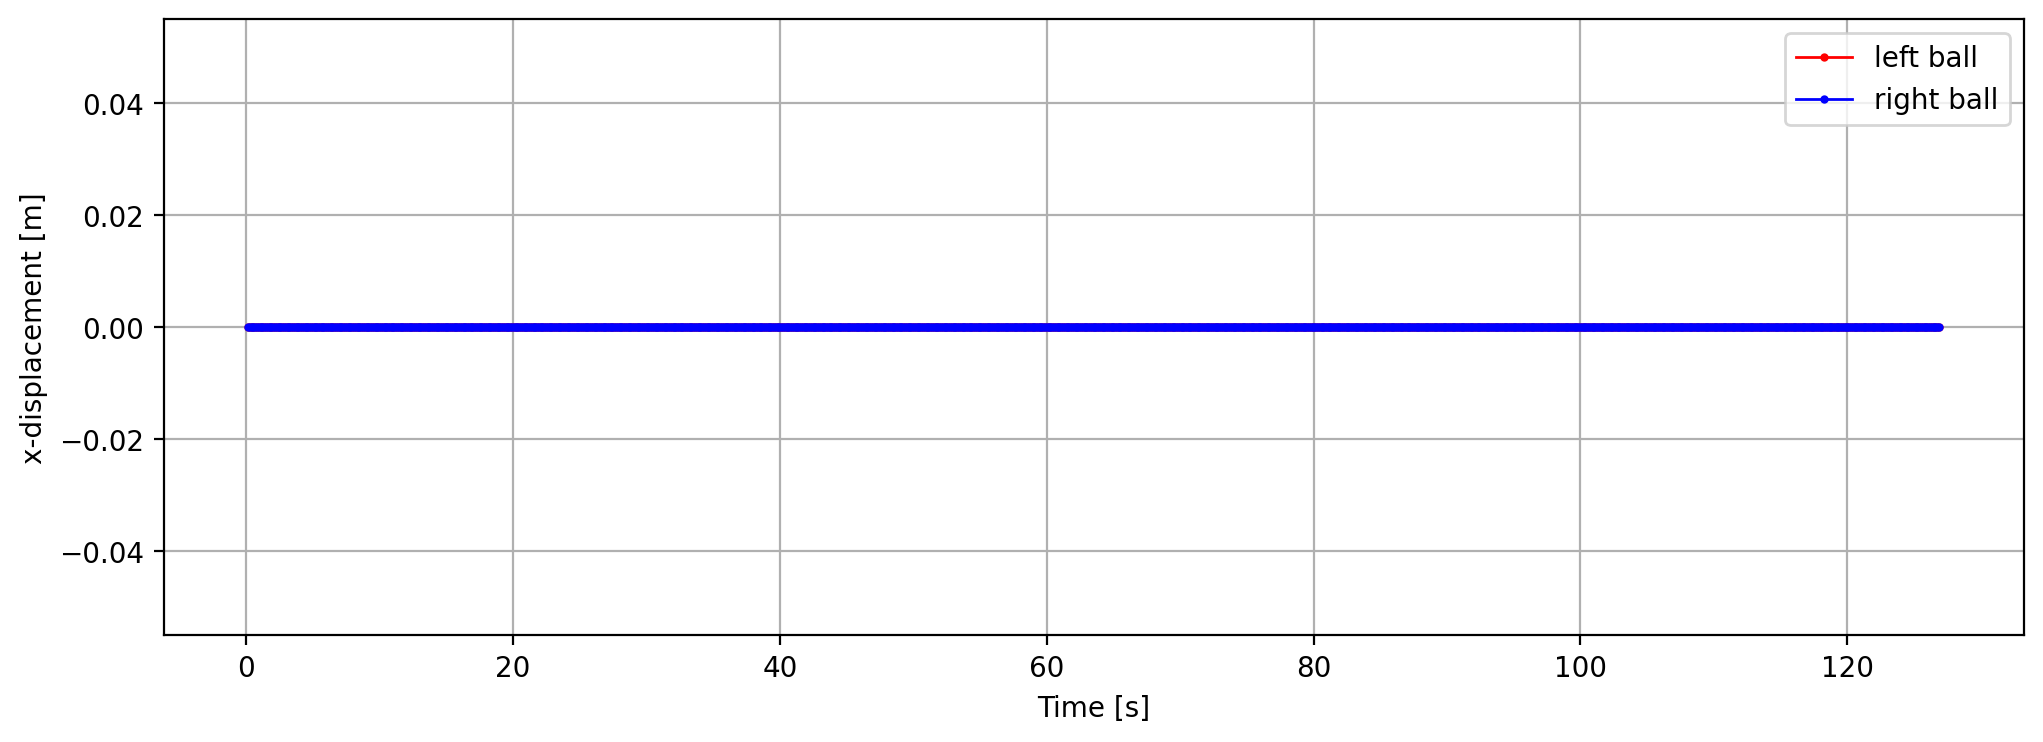

In [17]:
# If you want to plot the force magnitude vs timestep
plt.figure(figsize=(12,4))
plt.plot(data['timestep']*dt, np.abs(data['x1'] - data['x1'][0]) , 'o-', ms = 2,color = 'r', lw = 1, label = 'left ball')
plt.plot(data['timestep']*dt, np.abs(data['x2'] - data['x2'][0]), 'o-',ms = 2,color = 'b', lw = 1, label = 'right ball')
plt.xlabel('Time [s]')
plt.ylabel('x-displacement [m]')
plt.grid()
plt.legend()
plt.show()

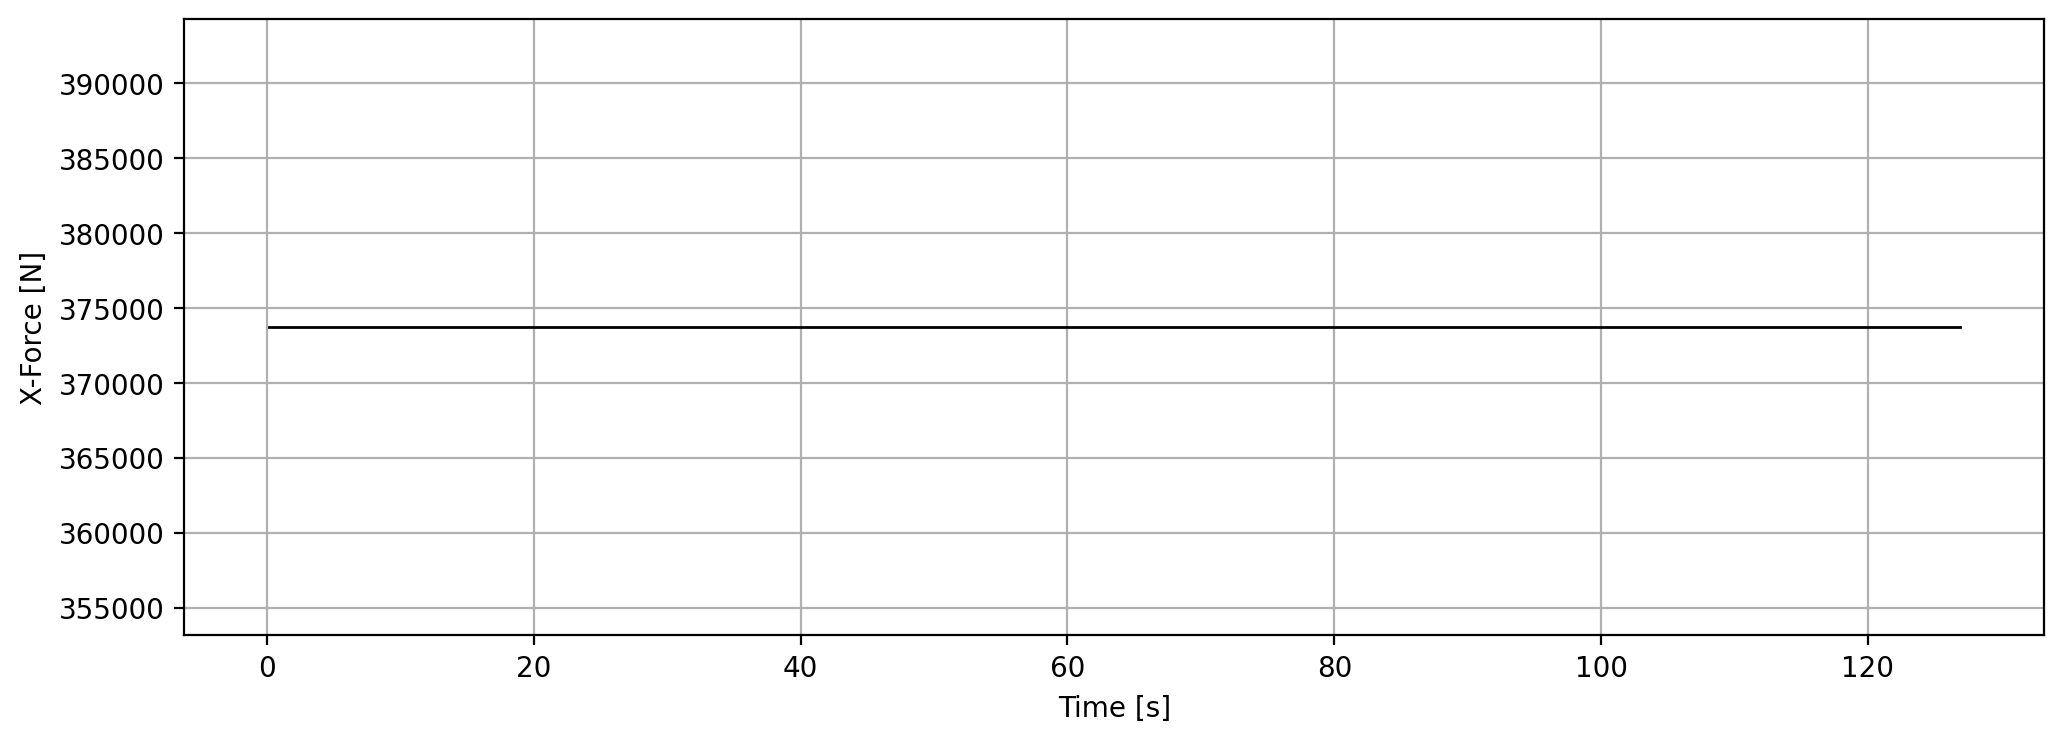

In [18]:
# If you want to plot the force magnitude vs timestep
plt.figure(figsize=(12,4))
plt.plot(data['timestep']*dt, data['fx'] , color = 'k', lw = 1, label = 'left ball')
plt.xlabel('Time [s]')
plt.ylabel('X-Force [N]')
plt.grid()
plt.show()

Now, let's read in the dump files and see if the force on the balls is different than what paraview computes. 

In [43]:
# Path to the directory containing the bond files
directory = "post"
# Variable names as they appear in the data lines
variable_names = ['id', 'type', 'x', 'y', 'z', 'id0',
        'id1', 'id2', 'id3', 'vx', 'vy', 'vz', 'fx', 'fy', 'fz',
        'omegax', 'omegay', 'omegaz', 'radius'
]

for filename in sorted(os.listdir(directory)):
    if filename.startswith("dump") and filename.endswith(".liggghts"):
        
        # Open and read the file
        with open(os.path.join(directory, filename), 'r') as file:
            lines = file.readlines()
            
            # Get number of atoms
            n_atoms = int(lines[3].strip())


# Initialize a dictionary to store lists for each variable
data_dict = {n: {var: [] for var in variable_names} for n in range(1, n_atoms+1)}

timesteps = []

# Loop over all files in the directory
for filename in sorted(os.listdir(directory)):
    if filename.startswith("dump") and filename.endswith(".liggghts"):
        
        # Open and read the file
        with open(os.path.join(directory, filename), 'r') as file:
            lines = file.readlines()
            
            # Extract the timestep; on the second line
            timestep = int(lines[1].strip())
            timesteps.append(timestep)

            # Get number of atoms
            n_atoms = int(lines[3].strip())

            # Extract the data line; data is on the last line
            for n in range(1,n_atoms+1):
                data_line = lines[n+8]
                vals = list(map(float, data_line.split()))
                
                # Store each data value under its corresponding variable name
                for i, var in enumerate(variable_names):
                    data_dict[n][var].append(vals[i])
                
# Create an xarray.Dataset using the collected data with the new structure
# dump = xr.Dataset(
#     {var: ("timestep", [data_dict[n][var] for n in range(1,n_atoms+1)][0]) for var in variable_names},
#     coords={"timestep": timesteps}
# )
# Create a nested xarray.Dataset


In [19]:
# Path to the directory containing the dump files
directory = "post_lower_force"
# Variable names as they appear in the data lines
variable_names = ['id', 'type', 'x', 'y', 'z', 'dt',
        'id1', 'id2', 'id3', 'vx', 'vy', 'vz', 'fx', 'fy', 'fz',
        'omegax', 'omegay', 'omegaz', 'radius'
]

# Initialize a dictionary to store lists for each variable
data_dict1 = {var: [] for var in variable_names}
data_dict2 = {var: [] for var in variable_names}
timesteps = []

# Loop over all files in the directory
for filename in sorted(os.listdir(directory)):
    if filename.startswith("dump") and filename.endswith(".liggghts"):
        
        # Open and read the file
        with open(os.path.join(directory, filename), 'r') as file:
            lines = file.readlines()
            
            # Extract the timestep; on the second line
            timestep = int(lines[1].strip())
            timesteps.append(timestep)


            # Extract the data line; data is on the last line
            data_line1 = lines[9]
            data_line2 = lines[10]
            vals1 = list(map(float, data_line1.split()))
            vals2 = list(map(float, data_line2.split()))
            
            # Store each data value under its corresponding variable name
            for i, var in enumerate(variable_names):
                data_dict1[var].append(vals1[i])
                data_dict2[var].append(vals2[i])

                
# Create an xarray.Dataset using the collected data
dump1 = xr.Dataset(
    {var: ("timestep", data_dict1[var]) for var in variable_names},
    coords={"timestep": timesteps}
)

# sort and display the dataset, also compute the force magnitude
dump1 = dump1.sortby("timestep")
dump1["force_magnitude"] = np.sqrt(dump1.fx**2 + dump1.fy**2 + dump1.fz**2)

dump2 = xr.Dataset(
    {var: ("timestep", data_dict2[var]) for var in variable_names},
    coords={"timestep": timesteps}
)

# sort and display the dataset, also compute the force magnitude
dump2 = dump2.sortby("timestep")
dump2["force_magnitude"] = np.sqrt(dump2.fx**2 + dump2.fy**2 + dump2.fz**2)


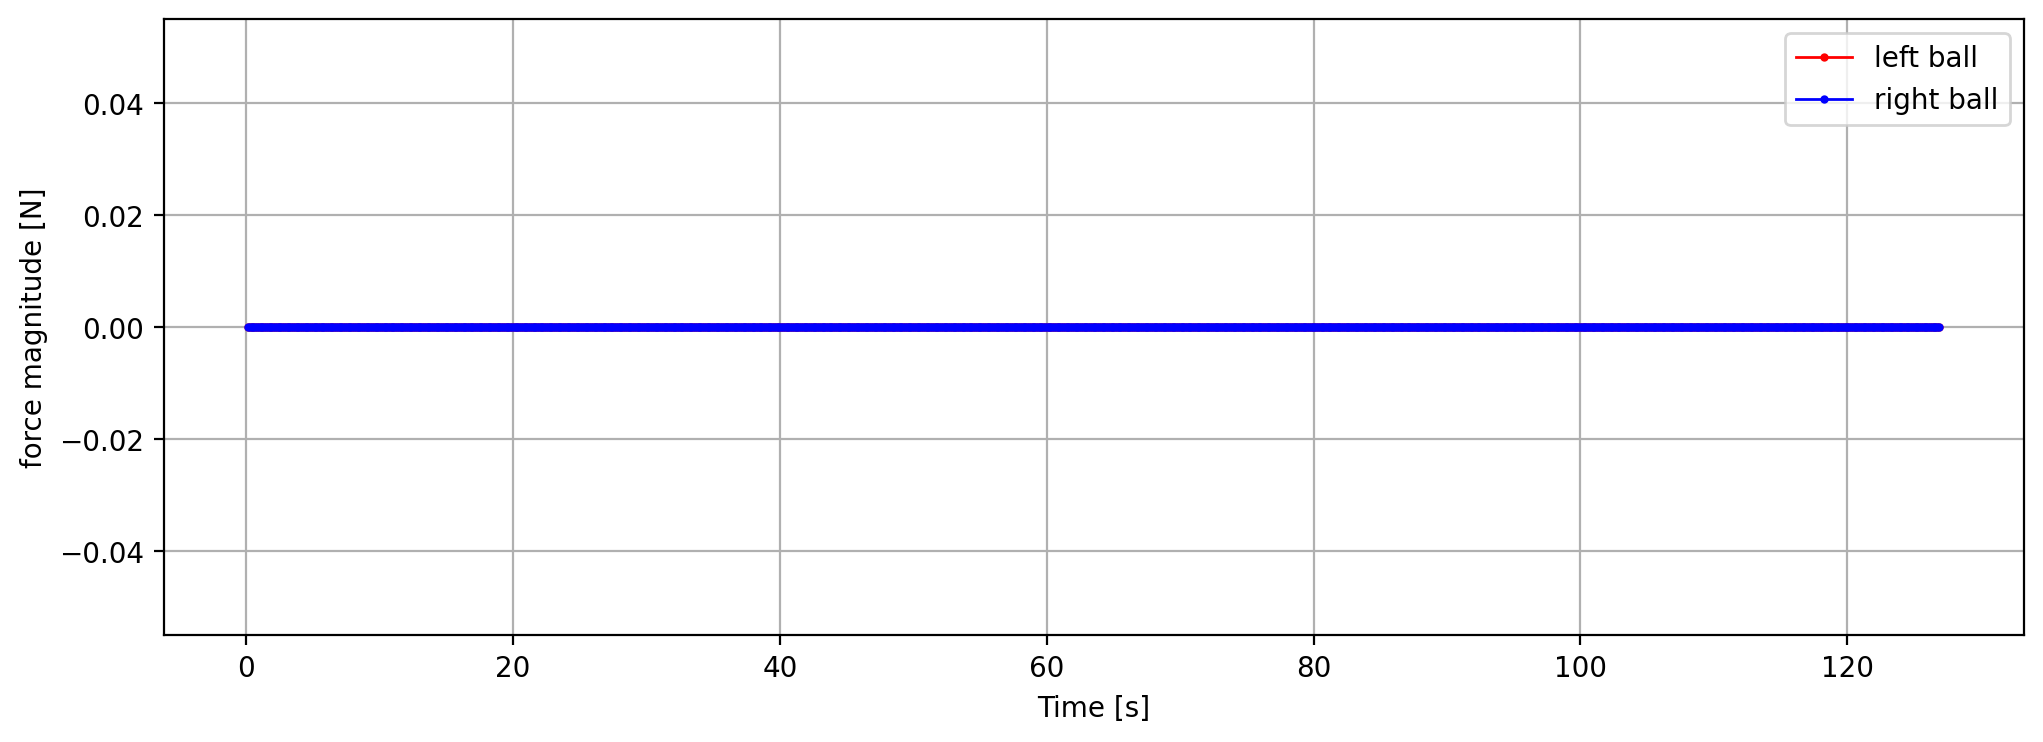

In [20]:
# If you want to plot the force magnitude vs timestep
plt.figure(figsize=(12,4))
plt.plot(dump1['timestep']*dt, dump1['force_magnitude'] , 'o-', ms = 2,color = 'r', lw = 1, label = 'left ball')
plt.plot(dump2['timestep']*dt, dump2['force_magnitude'] , 'o-',ms = 2,color = 'b', lw = 1, label = 'right ball')
plt.xlabel('Time [s]')
plt.ylabel('force magnitude [N]')
plt.grid()
plt.legend()
plt.show()

force agrees with paraview

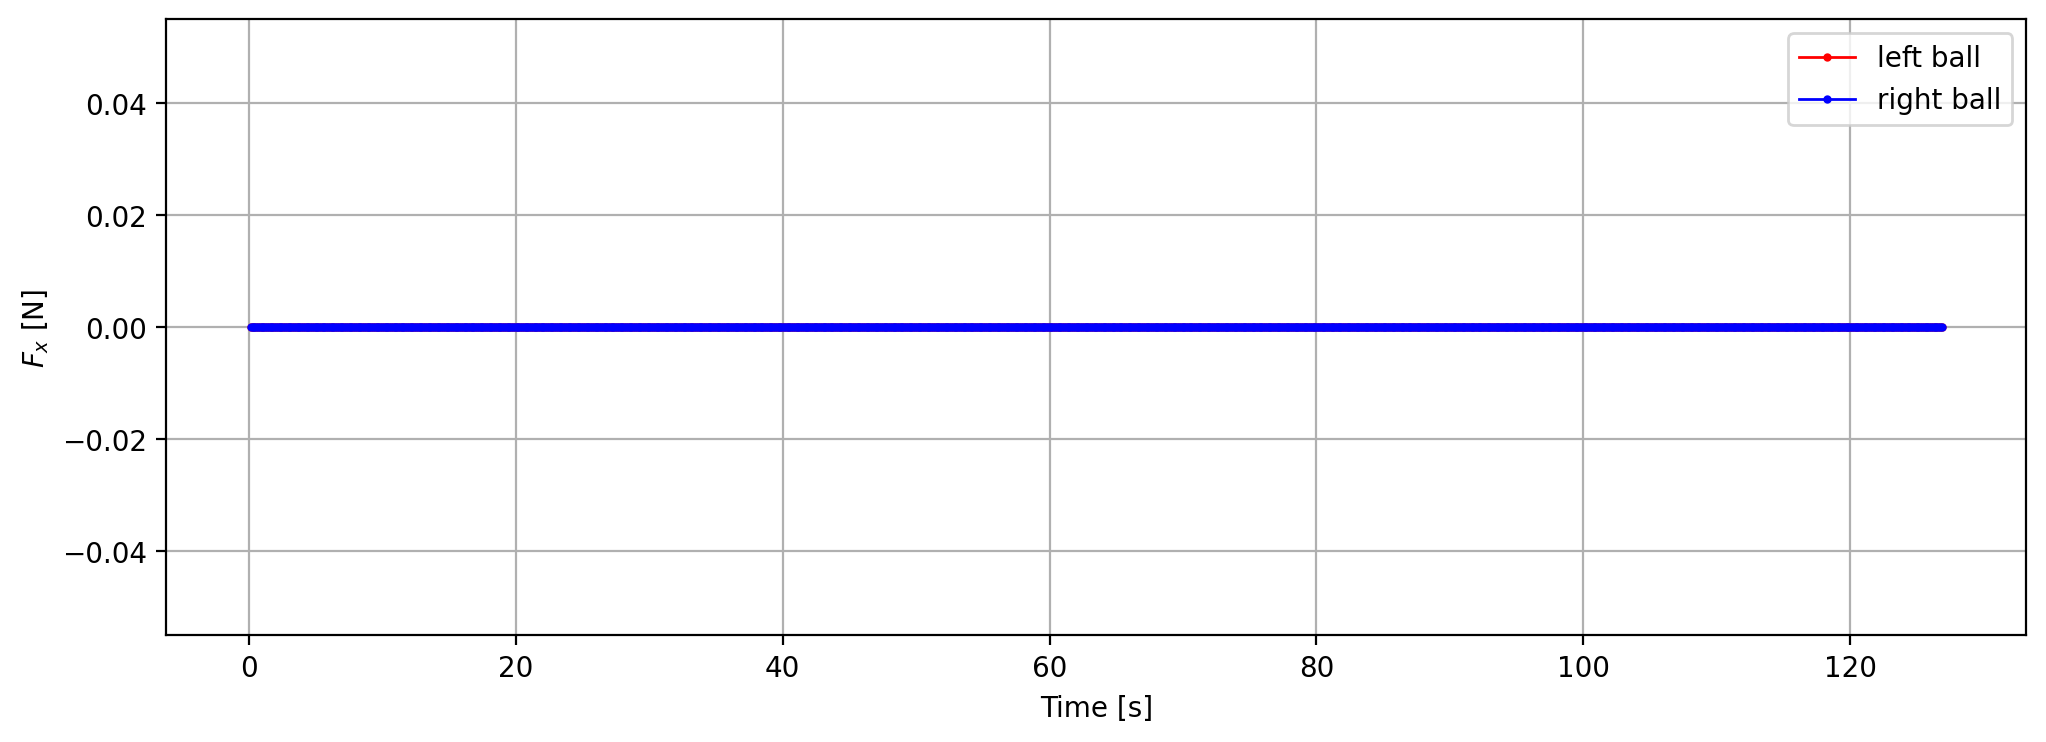

In [21]:
plt.figure(figsize=(12,4))
plt.plot(dump1['timestep']*dt, dump1['fx'] , 'o-', ms = 2,color = 'r', lw = 1, label = 'left ball')
plt.plot(dump2['timestep']*dt, dump2['fx'] , 'o-',ms = 2,color = 'b', lw = 1, label = 'right ball')
plt.xlabel('Time [s]')
plt.ylabel(r'$F_x$ [N]')
plt.grid()
plt.legend()
plt.show()

okay, velocity compared with paraview velocity seems right


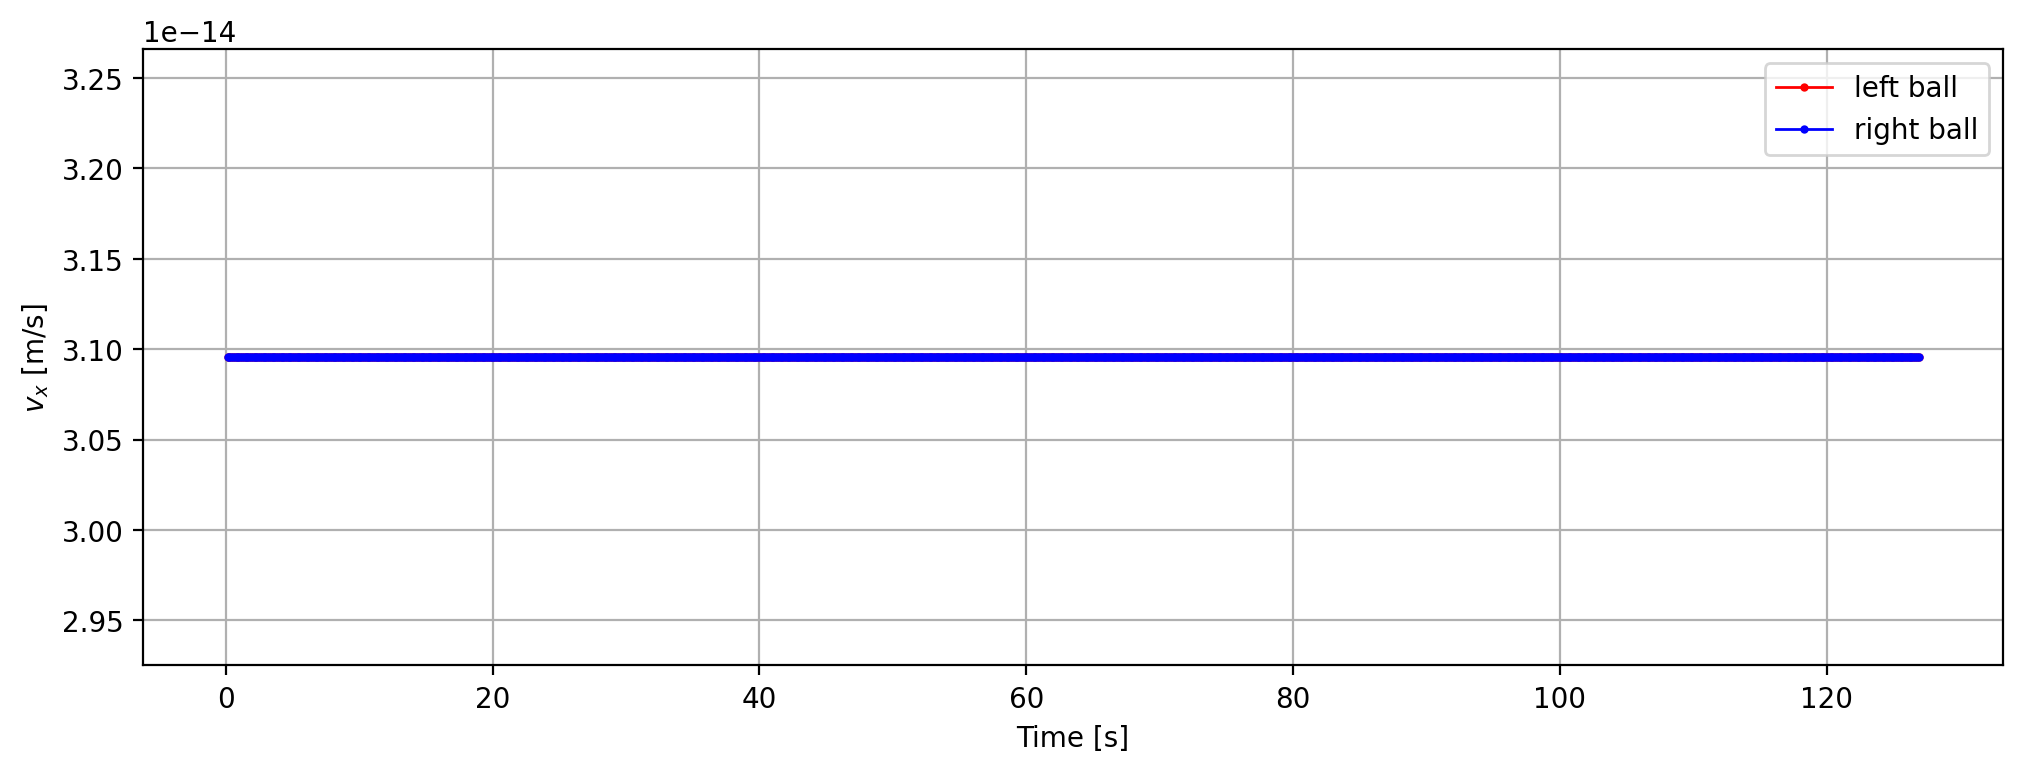

In [23]:
plt.figure(figsize=(12,4))
plt.plot(dump1['timestep']*dt, dump1['vx'], 'o-', ms = 2,color = 'r', lw = 1, label = 'left ball')
plt.plot(dump2['timestep']*dt, -dump2['vx'], 'o-',ms = 2,color = 'b', lw = 1, label = 'right ball')
plt.xlabel('Time [s]')
plt.ylabel(r'$v_x$ [m/s]')
plt.grid()
plt.legend()
plt.show()

Balls now have constant velocity really small velocity...? 

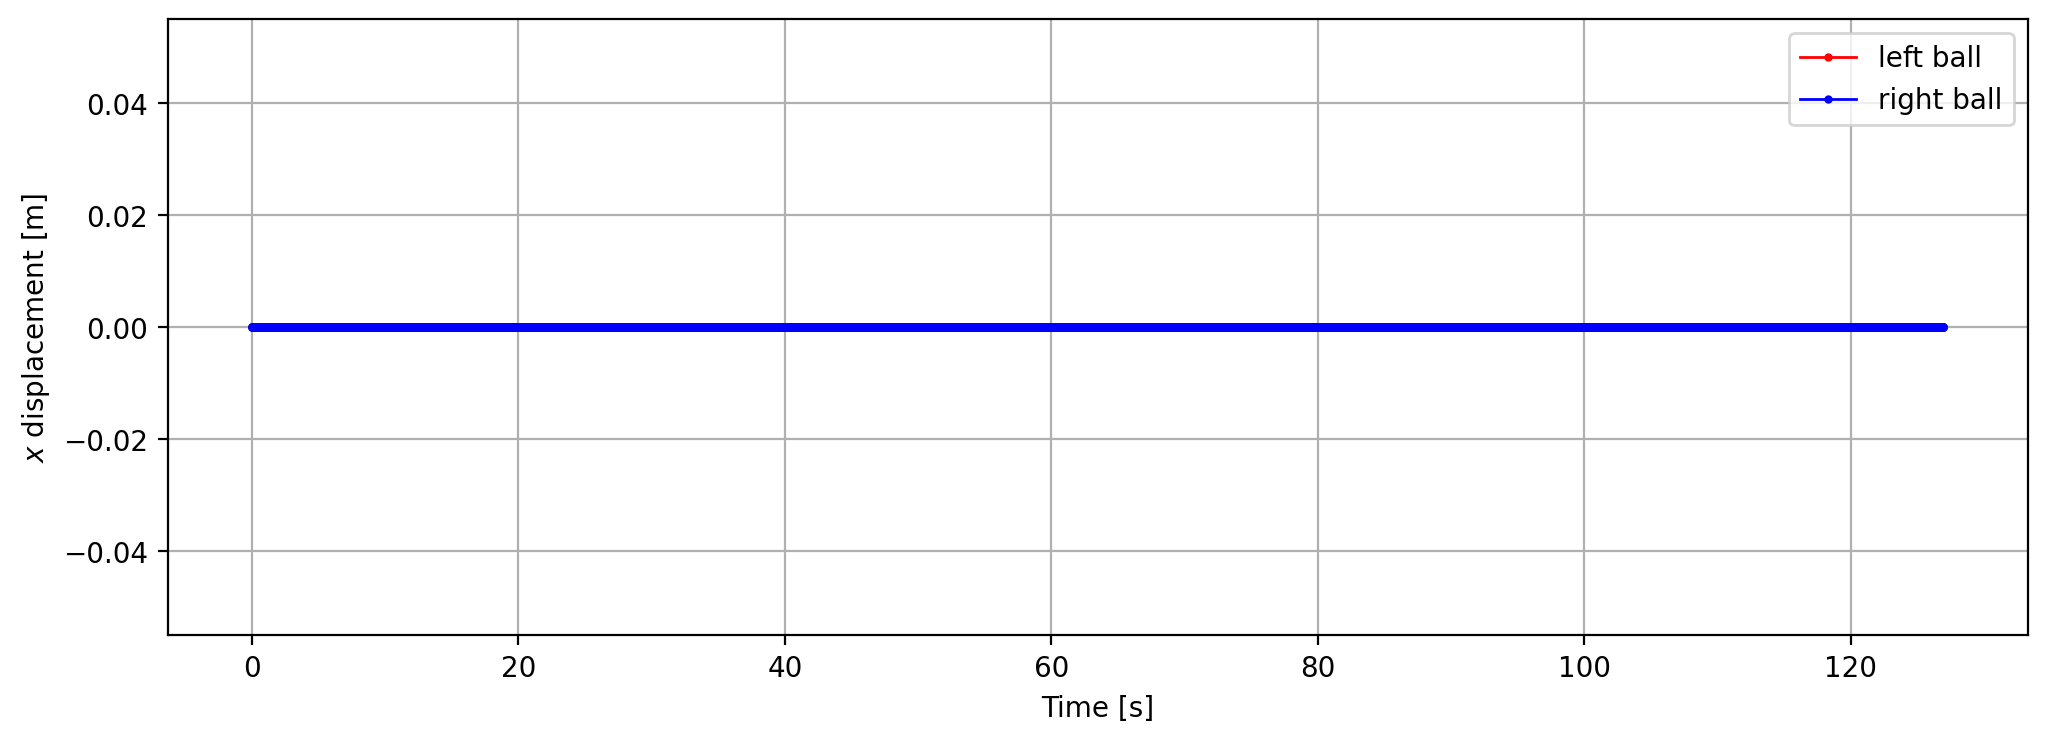

In [13]:
plt.figure(figsize=(12,4))
plt.plot(dump1['timestep']*dt, dump1['x'] - dump1['x'][0], 'o-', ms = 2,color = 'r', lw = 1, label = 'left ball')
plt.plot(dump2['timestep']*dt, dump2['x'] - dump2['x'][0], 'o-',ms = 2,color = 'b', lw = 1, label = 'right ball')
plt.xlabel('Time [s]')
plt.ylabel(r'$x$ displacement [m]')
plt.grid()
plt.legend()
plt.show()